# **Rezbin AI Model v2.0 Development**

We are fine-tuning a MbileNet model for a multi-class image classification of the TrashNet dataset.

In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

Opening our TrashNet dataset via `datasets` from `torchvision`

In [3]:
from pathlib import Path

# opening dataset
dataset_path = Path('../dataset-resized/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

Splitting our dataset by 80% training, and 20% testing

In [4]:
from torch.utils.data import random_split
from torchvision.transforms import v2

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)
    
# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

Plotting Dataset

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

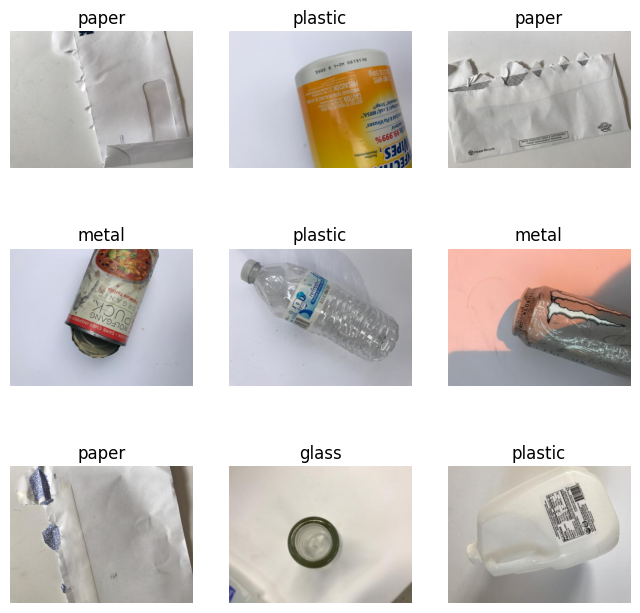

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img)
plt.show()

Let's define our basic preprocessing transformation pipeline, and plot it to see what it looks like. 

In [7]:
# defining transformation pipeline
transform = v2.Compose([
    # augmentation steps from paper
    v2.RandomAffine(
        degrees=5,
        translate=(0.2, 0.2),
        fill=0                     
    ),
    v2.RandomHorizontalFlip(),
    
    # Transform to image
    v2.Resize((256,256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [8]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


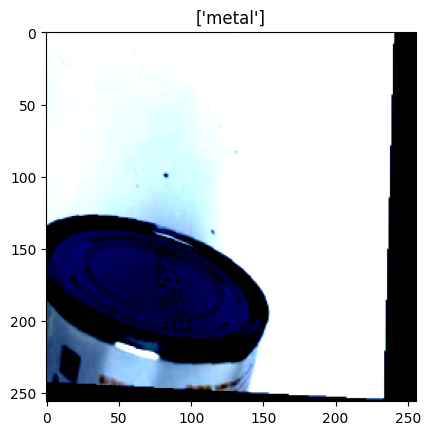

In [9]:
# Sample display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0)) # permute cause image is already transformed by preprocessing pipeline
plt.title([key for key, val in idx_labels.items() if val == label])
plt.show()

In [10]:
from torchvision import models
import torch.nn as nn
torch.cuda.empty_cache()

In [11]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
model = models.mobilenet_v2(pretrained=True)


c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)
model = model.to(device)


Define Loss and Optimizer

In [14]:
import torch.optim as optim

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is a good default choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training MobileNet

In [15]:
from tqdm import tqdm
import os

num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%")



100%|██████████| 32/32 [03:55<00:00,  7.37s/it]


Epoch [1/50], Loss: 0.7991, Accuracy: 70.06%


100%|██████████| 32/32 [03:27<00:00,  6.48s/it]


Epoch [2/50], Loss: 0.4593, Accuracy: 83.67%


100%|██████████| 32/32 [03:29<00:00,  6.54s/it]


Epoch [3/50], Loss: 0.3320, Accuracy: 87.63%


100%|██████████| 32/32 [03:35<00:00,  6.75s/it]


Epoch [4/50], Loss: 0.2764, Accuracy: 90.90%


100%|██████████| 32/32 [03:18<00:00,  6.19s/it]


Epoch [5/50], Loss: 0.2358, Accuracy: 92.08%


100%|██████████| 32/32 [03:22<00:00,  6.33s/it]


Epoch [6/50], Loss: 0.2253, Accuracy: 92.23%


100%|██████████| 32/32 [03:22<00:00,  6.34s/it]


Epoch [7/50], Loss: 0.1854, Accuracy: 93.07%


100%|██████████| 32/32 [03:20<00:00,  6.27s/it]


Epoch [8/50], Loss: 0.1949, Accuracy: 93.32%


100%|██████████| 32/32 [03:25<00:00,  6.41s/it]


Epoch [9/50], Loss: 0.1687, Accuracy: 94.16%


100%|██████████| 32/32 [03:15<00:00,  6.11s/it]


Epoch [10/50], Loss: 0.1921, Accuracy: 93.77%


100%|██████████| 32/32 [03:17<00:00,  6.17s/it]


Epoch [11/50], Loss: 0.1640, Accuracy: 94.21%


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]


Epoch [12/50], Loss: 0.1458, Accuracy: 95.00%


100%|██████████| 32/32 [03:13<00:00,  6.04s/it]


Epoch [13/50], Loss: 0.1024, Accuracy: 96.83%


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]


Epoch [14/50], Loss: 0.0866, Accuracy: 97.18%


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]


Epoch [15/50], Loss: 0.0718, Accuracy: 97.48%


100%|██████████| 32/32 [03:11<00:00,  5.99s/it]


Epoch [16/50], Loss: 0.0964, Accuracy: 96.88%


100%|██████████| 32/32 [03:13<00:00,  6.05s/it]


Epoch [17/50], Loss: 0.0894, Accuracy: 96.88%


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]


Epoch [18/50], Loss: 0.0897, Accuracy: 96.88%


100%|██████████| 32/32 [03:11<00:00,  5.98s/it]


Epoch [19/50], Loss: 0.0768, Accuracy: 97.33%


100%|██████████| 32/32 [03:11<00:00,  5.98s/it]


Epoch [20/50], Loss: 0.0845, Accuracy: 97.03%


100%|██████████| 32/32 [03:11<00:00,  5.98s/it]


Epoch [21/50], Loss: 0.0903, Accuracy: 96.68%


100%|██████████| 32/32 [03:11<00:00,  5.99s/it]


Epoch [22/50], Loss: 0.0693, Accuracy: 97.33%


100%|██████████| 32/32 [03:14<00:00,  6.09s/it]


Epoch [23/50], Loss: 0.1344, Accuracy: 95.99%


100%|██████████| 32/32 [03:16<00:00,  6.14s/it]


Epoch [24/50], Loss: 0.1452, Accuracy: 95.15%


100%|██████████| 32/32 [03:26<00:00,  6.44s/it]


Epoch [25/50], Loss: 0.1213, Accuracy: 96.09%


100%|██████████| 32/32 [03:21<00:00,  6.31s/it]


Epoch [26/50], Loss: 0.1449, Accuracy: 95.60%


100%|██████████| 32/32 [03:16<00:00,  6.14s/it]


Epoch [27/50], Loss: 0.1017, Accuracy: 96.29%


100%|██████████| 32/32 [03:14<00:00,  6.09s/it]


Epoch [28/50], Loss: 0.0480, Accuracy: 98.42%


100%|██████████| 32/32 [03:15<00:00,  6.12s/it]


Epoch [29/50], Loss: 0.0345, Accuracy: 98.61%


100%|██████████| 32/32 [03:15<00:00,  6.12s/it]


Epoch [30/50], Loss: 0.0228, Accuracy: 99.21%


100%|██████████| 32/32 [03:15<00:00,  6.11s/it]


Epoch [31/50], Loss: 0.0223, Accuracy: 99.26%


100%|██████████| 32/32 [03:15<00:00,  6.12s/it]


Epoch [32/50], Loss: 0.0219, Accuracy: 99.21%


100%|██████████| 32/32 [03:15<00:00,  6.11s/it]


Epoch [33/50], Loss: 0.0172, Accuracy: 99.41%


100%|██████████| 32/32 [03:15<00:00,  6.11s/it]


Epoch [34/50], Loss: 0.0375, Accuracy: 98.71%


100%|██████████| 32/32 [03:16<00:00,  6.14s/it]


Epoch [35/50], Loss: 0.0421, Accuracy: 98.52%


100%|██████████| 32/32 [03:16<00:00,  6.14s/it]


Epoch [36/50], Loss: 0.0765, Accuracy: 97.18%


100%|██████████| 32/32 [03:15<00:00,  6.11s/it]


Epoch [37/50], Loss: 0.0971, Accuracy: 96.98%


100%|██████████| 32/32 [03:14<00:00,  6.08s/it]


Epoch [38/50], Loss: 0.1097, Accuracy: 96.68%


100%|██████████| 32/32 [03:16<00:00,  6.13s/it]


Epoch [39/50], Loss: 0.0487, Accuracy: 98.27%


100%|██████████| 32/32 [03:15<00:00,  6.12s/it]


Epoch [40/50], Loss: 0.0509, Accuracy: 98.32%


100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


Epoch [41/50], Loss: 0.0209, Accuracy: 99.11%


100%|██████████| 32/32 [03:17<00:00,  6.18s/it]


Epoch [42/50], Loss: 0.0202, Accuracy: 99.21%


100%|██████████| 32/32 [03:13<00:00,  6.04s/it]


Epoch [43/50], Loss: 0.0238, Accuracy: 99.26%


100%|██████████| 32/32 [03:13<00:00,  6.03s/it]


Epoch [44/50], Loss: 0.0222, Accuracy: 99.55%


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]


Epoch [45/50], Loss: 0.0222, Accuracy: 99.36%


100%|██████████| 32/32 [03:11<00:00,  6.00s/it]


Epoch [46/50], Loss: 0.0659, Accuracy: 97.87%


100%|██████████| 32/32 [03:11<00:00,  6.00s/it]


Epoch [47/50], Loss: 0.1124, Accuracy: 96.29%


100%|██████████| 32/32 [03:11<00:00,  5.99s/it]


Epoch [48/50], Loss: 0.1427, Accuracy: 95.45%


100%|██████████| 32/32 [03:14<00:00,  6.09s/it]


Epoch [49/50], Loss: 0.0829, Accuracy: 97.08%


100%|██████████| 32/32 [03:15<00:00,  6.12s/it]

Epoch [50/50], Loss: 0.0593, Accuracy: 97.87%


In [16]:
# Evaluation
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 87.94%


In [17]:
# Save model
save_dir = '../models/'
save_path = os.path.join(save_dir, '01_mobilenetv2_finetuned.pth')
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved successfully to {save_path}")


Model saved successfully to ../models/01_mobilenetv2_finetuned.pth
